
<div style='text-align:center'> 
<h1>Aplicação de Rede Neural Recorrente LSTM para predição de investimentos em criptomoedas</h1>
</div>

<h2>Sumário</h2>

<div> A estrutura do projeto está na seguinte forma:
<ul>
<li>Dependências</li>
<li>Configuração do notebook</li>
<li>Coleta de dados</li>
<li>Pré-processamento</li>
<li>Construção do modelo</li>
<li>Treinamento</li>
<li>Avaliação do modelo</li>
<li>Visualização Gráfica</li>
</ul>
</div>

<h2>Dependências</h2>

<h4>Libs para pré-processamento e visualização</h4>

In [1]:
from yahoo_fin.stock_info import get_data
from datetime import datetime
from matplotlib import rcParams

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import os
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import callbacks
from time import time

import keras_tuner
from keras_tuner.tuners import RandomSearch,BayesianOptimization

from keras.utils import plot_model

from tensorflow import keras
from tensorflow.keras import layers

<h2>Configuração do notebook</h2>

In [2]:
rcParams['figure.figsize'] = 10,8
warnings.filterwarnings('ignore')

<h2>Coleta de dados</h2>

In [3]:
def download_data(ativo, start, end):
    dataframe = get_data(ativo, start_date=start, end_date=end, index_as_date = True, interval="1d")
    dataframe = dataframe.dropna()
    return dataframe

In [4]:
ativo = 'BTC-USD'
start = dt.datetime(2020,1,1)
end = dt.datetime(2023,3,22)

In [5]:
dataset = download_data(ativo, start, end)

In [6]:
dataset.head(3)

,open,high,low,close,adjclose,volume,ticker
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,BTC-USD
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,BTC-USD
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,BTC-USD


<h2>Pré-processamento</h2>

In [7]:
dataset_total = dataset.iloc[:,3:4].dropna()
dataset_total.head(3)

,close
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277


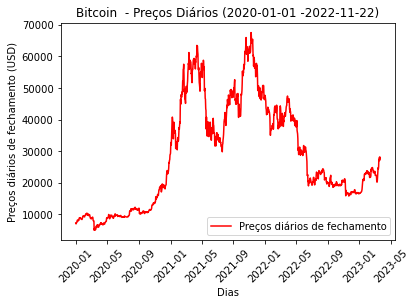

In [8]:
plt.plot(dataset_total['close'], label='Preços diários de fechamento', color='red')
plt.legend(loc='best')
plt.xlabel('Dias')
plt.xticks(rotation=45)
plt.ylabel('Preços diários de fechamento (USD)')
plt.title('Bitcoin  - Preços Diários (2020-01-01 -2022-11-22)')
plt.show()

<h2>Construção do Modelo</h2>

<div>
<ul>Referência Michánków et al. 2022:   
    <li>3 Camadas de LSTM</li>
    <li>512/256/128 neurônios</li>
    <li>Dropout: 0,02 </li>    <li>1 Neurônio de saida</li>
    <li>Função de ativação: tanh</li>
    <li>Otimizador: Adam</li>
    <li>Taxa: 0,0015</li>
    <li>Mini-Batch: 80</li>
    <li>Loss: MDSL</li>
</ul>
</div>    

<div style='text-aling:justify'>
O objetivo do modelo é avaliar sua capacidade de predição dos valores em 60 dias;
</div>

<h4>Normalização dos dados</h4>

In [9]:
dataset_values = dataset_total.values
    
training_dataset_len = math.ceil(len(dataset_values)* 0.67) # 80% training
    
mms = MinMaxScaler(feature_range=(0,1))                           # range for to scale (0,1)
    
scaled_dataset = mms.fit_transform(dataset_values.reshape(-1,1))  # normalized dataset and reshape(-1,1)

training_dataset = scaled_dataset[0: training_dataset_len, :]   

In [10]:
training_dataset.shape

(789, 1)

<h4>Construção do dataset de treino e teste</h4>

In [11]:
qt_days = 60

In [12]:
X_train = []
y_train = []

for i in range(qt_days, len(training_dataset)):
    X_train.append(training_dataset[i-qt_days:i, 0])
    y_train.append(training_dataset[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
len(X_train), len(y_train)

(729, 729)

In [14]:
test_dataset = scaled_dataset[training_dataset_len-qt_days: , : ]

x_test = []

y_test = dataset_values[training_dataset_len:]

for i in range(qt_days, len(test_dataset)):
    x_test.append(test_dataset[i-qt_days:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
len(x_test), len(y_test), len(scaled_dataset)

(388, 388, 1177)

<h2>Treinamento</h2>

In [16]:
from tensorflow.keras.optimizers import Adam

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import callbacks
from time import time

<h4>Base Model</h4>

In [18]:
import keras_tuner
from keras_tuner.tuners import RandomSearch,BayesianOptimization

In [19]:
inputs = keras.Input(shape=(X_train.shape[1],1), name='input_layer')

x = layers.LSTM(50, return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(50, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(50)(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='tanh')(x)

In [20]:
network = keras.Model(inputs=inputs, 
                      outputs=outputs, 
                      name='network_lstm_model')

In [21]:
network.summary()

Model: "network_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)         

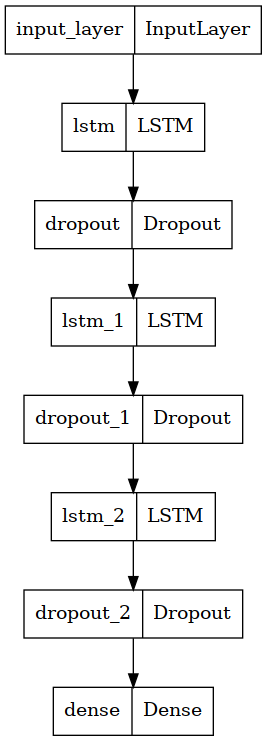

In [22]:
keras.utils.plot_model(network, '../plots/lstm_model_shape_false.png')

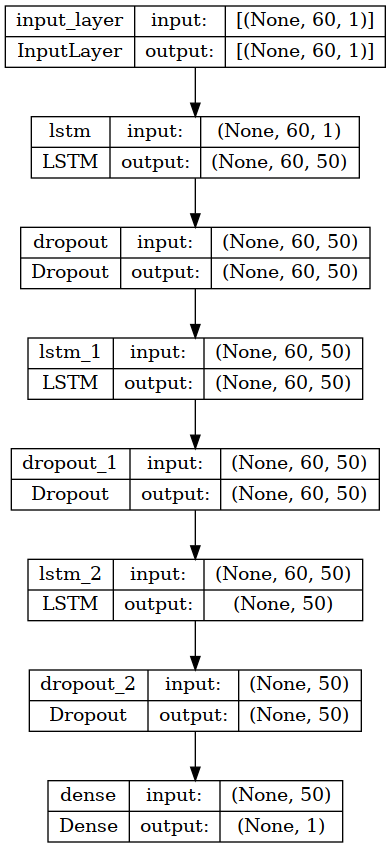

In [23]:
keras.utils.plot_model(network, '../plots/model_lstm.png', show_shapes=True)

In [24]:
# optimizer = Adam(learning_rate=0.2)

network.compile(optimizer="adam",loss='mse')

In [25]:
tensorboard = TensorBoard(log_dir="../logs/{}".format(time()))

In [26]:
history = network.fit(X_train, 
                      y_train,
                      epochs=96,
                      batch_size=32,
                      callbacks=[tensorboard], 
                      verbose=2)

Epoch 1/96
23/23 - 19s - loss: 0.0531 - 19s/epoch - 823ms/step
Epoch 2/96
23/23 - 5s - loss: 0.0079 - 5s/epoch - 233ms/step
Epoch 3/96
23/23 - 5s - loss: 0.0067 - 5s/epoch - 227ms/step
Epoch 4/96
23/23 - 6s - loss: 0.0058 - 6s/epoch - 241ms/step
Epoch 5/96
23/23 - 16s - loss: 0.0062 - 16s/epoch - 682ms/step
Epoch 6/96
23/23 - 6s - loss: 0.0054 - 6s/epoch - 265ms/step
Epoch 7/96
23/23 - 6s - loss: 0.0057 - 6s/epoch - 254ms/step
Epoch 8/96
23/23 - 6s - loss: 0.0051 - 6s/epoch - 249ms/step
Epoch 9/96
23/23 - 6s - loss: 0.0054 - 6s/epoch - 282ms/step
Epoch 10/96
23/23 - 5s - loss: 0.0050 - 5s/epoch - 229ms/step
Epoch 11/96
23/23 - 6s - loss: 0.0046 - 6s/epoch - 242ms/step
Epoch 12/96
23/23 - 5s - loss: 0.0045 - 5s/epoch - 226ms/step
Epoch 13/96
23/23 - 6s - loss: 0.0042 - 6s/epoch - 240ms/step
Epoch 14/96
23/23 - 6s - loss: 0.0045 - 6s/epoch - 242ms/step
Epoch 15/96
23/23 - 5s - loss: 0.0042 - 5s/epoch - 226ms/step
Epoch 16/96
23/23 - 6s - loss: 0.0042 - 6s/epoch - 247ms/step
Epoch 17/96
2

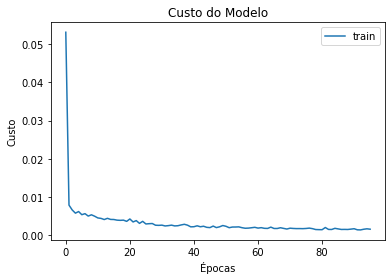

In [50]:
plt.plot(history.history['loss'])
plt.title('Custo do Modelo')
plt.ylabel('Custo')
plt.xlabel('Épocas')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [51]:
# plt.plot(history.history['loss'])
# plt.title('Custo do Modelo')
# plt.ylabel('Custo')
# plt.xlabel('Épocas')
# # plt.legend(['train', 'val'], loc='upper left')
# plt.show()

<h2>Avaliação do Modelo</h2>

In [28]:
print("Evaluate on test data \n")

results = network.evaluate(x_test, y_test, verbose=2)

print("test loss:", results)

Evaluate on test data 

13/13 - 3s - loss: 699570560.0000 - 3s/epoch - 226ms/step
test loss: 699570560.0


In [65]:
predictions = network.predict(x_test)

predictions.shape

13/13 [==============================] - 1s 98ms/step


(388, 1)

In [66]:
predictions = mms.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)

print(f"RMSE: {rmse}")

RMSE: 1546.4112183875645


In [67]:
# predictions = mms.inverse_transform(predictions)

mae = np.sqrt(np.mean(predictions - y_test))

print(f"MAE: {mae}")

MAE: 39.32443538548983


In [70]:
from sklearn.metrics import mean_absolute_error

mape = mean_absolute_error(predictions, y_test)*100

print(f"MAPE: {mape}")

MAPE: 171731.74079816366


<h2>Visualização Gráfica</h2>

In [31]:
data = dataset.filter(['close'])

train = data[:training_dataset_len]

In [32]:
data

,close
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383
...,...
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,28175.816406


In [33]:
validation = data[training_dataset_len:]

validation

,close
2022-02-28,43193.234375
2022-03-01,44354.636719
2022-03-02,43924.117188
2022-03-03,42451.789062
2022-03-04,39137.605469
...,...
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,28175.816406


In [34]:
validation['predictions'] = predictions

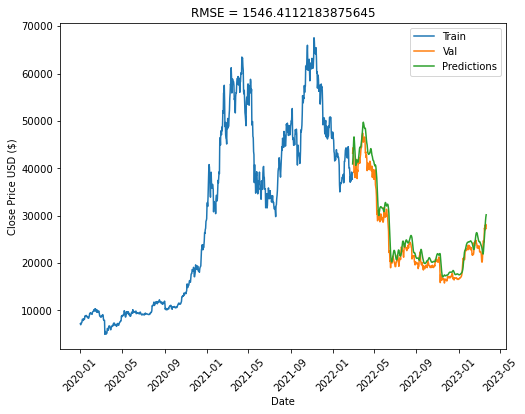

In [35]:
plt.figure(figsize=(8,6))
plt.title(f"RMSE = {rmse}")
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['close', 'predictions']])
plt.xticks(rotation=45)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.savefig("")
plt.show()

<h2>Predizendo o próximo dia</h2>

In [36]:
x_test

array([[[0.67428126],
        [0.66035579],
        [0.68240778],
        ...,
        [0.54705426],
        [0.54531182],
        [0.52302026]],

       [[0.66035579],
        [0.68240778],
        [0.67695066],
        ...,
        [0.54531182],
        [0.52302026],
        [0.61062084]],

       [[0.68240778],
        [0.67695066],
        [0.66277881],
        ...,
        [0.52302026],
        [0.61062084],
        [0.62917476]],

       ...,

       [[0.25746045],
        [0.28285758],
        [0.28447226],
        ...,
        [0.35869907],
        [0.35138151],
        [0.36851992]],

       [[0.28285758],
        [0.28447226],
        [0.28355832],
        ...,
        [0.35138151],
        [0.36851992],
        [0.36418355]],

       [[0.28447226],
        [0.28355832],
        [0.28697732],
        ...,
        [0.36851992],
        [0.36418355],
        [0.3707108 ]]])

In [37]:
real_data = [x_test[len(x_test)+1 - qt_days:len(x_test+1),0]]

real_data = np.array(real_data)

real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = network.predict(real_data)

prediction = mms.inverse_transform(prediction)

print(f"prediction: {prediction}")

1/1 [==============================] - 1s 1s/step
prediction: [[23265.023]]


In [38]:
# Configuração das datas:

START_DATE = dt.datetime(2023,3,22)
END_DATE = dt.datetime(2023,3,24)

In [39]:
dataset = get_data('BTC-USD', 
                   start_date=START_DATE, 
                   end_date=END_DATE, 
                   index_as_date = True, 
                   interval="1d")

dataset = dataset.dropna()

dataset[['close']]

,close
2023-03-22,27307.437500
2023-03-23,28333.972656
2023-03-24,27493.285156


In [40]:
validation.tail(3)

,close,predictions
2023-03-20,27767.236328,28937.816406
2023-03-21,28175.816406,29698.064453
2023-03-22,27307.437500,30198.990234


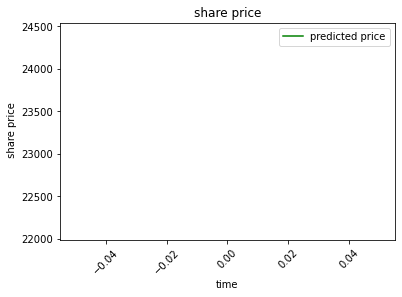

In [47]:
# plt.plot(dataset['close'], color='red', label="Preço Real out")
# plt.plot(y_test, color='black', label="Actual price")
plt.plot(prediction, color= 'green', label="predicted price")
plt.title("share price")
plt.xlabel("time")
plt.ylabel(" share price")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()